In [1]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from PIL import Image
import datetime
from utils.plotting import showFlow, overlaySegment
from utils.encoding import dice_coeff, hausdorff_dist
from utils.load_models import load_flownet2, load_pwcnet
from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.layers import warp
import time

import warnings
warnings.filterwarnings('ignore')

# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7fcb881af940>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [2]:
W,H = (150,150)
o_m = H//4 +1
o_n = W//4 +1
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
disp_range = 0.25#0.25
disp_hw = 5
displace_range = 11

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features
    
    
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(4)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(pad2(ssd_minconv)))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    
    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

In [3]:

path_to_state_dict = "models/Experiment_1/obel16_mix_WL_06_01_22-11-38.pth"
model_classic = OBELISK2d(16)
model_classic.load_state_dict(torch.load(path_to_state_dict))
model_classic.eval().cuda()

path_to_state_dict = "models/Experiment_2/obel16_ensemble_13_10_21-21-30.pth"
model_kc = OBELISK2d(16)
model_kc.load_state_dict(torch.load(path_to_state_dict))
model_kc.eval().cuda()

path_to_state_dict = "models/Experiment_3/27_10_21-10-59/student_16_1.pth"
model_dml = OBELISK2d(16)
model_dml.load_state_dict(torch.load(path_to_state_dict))
model_dml.eval().cuda()

"""

path_to_state_dict = "models/Experiment_2/fineTune/Tuned_Epoch195.pth"
model_classic = OBELISK2d(16)
model_classic.load_state_dict(torch.load(path_to_state_dict))
model_classic.eval().cuda()

path_to_state_dict = "models/Experiment_2/fineTuneSoft/tuned.pth"
model_kc = OBELISK2d(16)
model_kc.load_state_dict(torch.load(path_to_state_dict))
model_kc.eval().cuda()
"""

'\n\npath_to_state_dict = "models/Experiment_2/fineTune/Tuned_Epoch195.pth"\nmodel_classic = OBELISK2d(16)\nmodel_classic.load_state_dict(torch.load(path_to_state_dict))\nmodel_classic.eval().cuda()\n\npath_to_state_dict = "models/Experiment_2/fineTuneSoft/tuned.pth"\nmodel_kc = OBELISK2d(16)\nmodel_kc.load_state_dict(torch.load(path_to_state_dict))\nmodel_kc.eval().cuda()\n'

In [4]:
baseline = cv2.optflow.DualTVL1OpticalFlow_create()
pwc = load_pwcnet().cuda()
flownet = load_flownet2().cuda()

In [5]:
def pdd_warp(model, fixed, moving, fixed_seg, moving_seg):
    model = model.eval()
    
    start = time.time()
    feat1 = model(moving.unsqueeze(0).unsqueeze(0).cuda())
    feat2 = model(fixed.unsqueeze(0).unsqueeze(0).cuda())
    ssd_distance = correlation_layer(displace_range, feat2, feat1)
    soft_cost,disp_xy = meanfield(ssd_distance, moving, displace_range, H//4 +1, W//4 +1)
    # scaling
    flow=F.interpolate(disp_xy,size=(150,150), mode='bicubic')
    end = time.time()
    run_time = round(end-start, 4)
    
    identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False)
    warped_student_seg = F.grid_sample(fixed_seg.unsqueeze(0).unsqueeze(0).float(),identity+flow.detach().cpu().permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

    return warped_student_seg, run_time

def warp_baseline(torch_flow, seg):
    B, C, H, W = torch_flow.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()

    vgrid = grid + torch_flow

    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    warped_seg_grid = nn.functional.grid_sample(seg.float().unsqueeze(0).unsqueeze(0), vgrid)
    return warped_seg_grid

def eval_baseline(fixed, moving, fixed_seg, moving_seg):
    
    # prepare for baseline
    in1 = moving.view(H,W,1).numpy().astype(np.float32)
    in2 = fixed.view(H,W,1).numpy().astype(np.float32)
    
    start = time.time()
    # run baseline
    baseline_flow = baseline.calc(in1,in2,None)
    end = time.time()
    run_time = round(end-start, 4)
    
    # warp 
    warped_seg = warp_baseline(torch.from_numpy(baseline_flow.T).unsqueeze(0), fixed_seg)
    d0 = dice_coeff(moving_seg, warped_seg, 3)
    return d0, run_time


def flownet_warp(fixed, moving, fixed_seg, moving_seg):
    scale=4
    B,C,H,W = fixed.shape
    teacher_fixed = F.interpolate(fixed, size=(4*64,4*64), mode='bicubic')
    teacher_moving = F.interpolate(moving, size=(4*64,4*64), mode='bicubic')
    # Generate the teacher flow estimation
    flow_in = preprocessing_flownet(teacher_moving.reshape(scale*64,scale*64,1),teacher_fixed.reshape(scale*64,scale*64,1))
    
    start = time.time()
    
    flownet_flow = flownet(flow_in.cuda()).cpu()
    
    end = time.time()
    run_time = end-start
    
    flownet_flow = F.interpolate(flownet_flow, size=(H,W), mode='bicubic')

    # warp segmentation with flownet flow
    warped_flownet_seg = warp(fixed_seg.float().unsqueeze(0).unsqueeze(0), flownet_flow)
    
    return warped_flownet_seg, run_time

def pwc_warp(fixed, moving, fixed_seg, moving_seg):
    scale=4
    B,C,H,W = fixed.shape
    
    teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
    teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')

    # Generate the teacher flow estimation
    pwc_flow_in = preprocessing_pwc(teacher_moving.detach().clone().reshape(scale*64,scale*64,1),teacher_fixed.detach().clone().reshape(scale*64,scale*64,1))
    
    start = time.time()
    pwc_flow = pwc(pwc_flow_in.cuda()).cpu()
    pwc_flow = pwc_flow[0] * 20.0
    
    end = time.time()
    run_time = end-start
    
    pwc_flow = F.interpolate(pwc_flow.unsqueeze(0), size=(H,W)).cpu()

    # warp the segmentations with pwc flow
    warped_pwc_seg = warp(fixed_seg.float().unsqueeze(0).unsqueeze(0), pwc_flow).cpu()
    
    return warped_pwc_seg, run_time

In [8]:
def eval_id(frames, segs, last_segment_available):
    distance_between_frames = 6


    classic_dice = []#torch.zeros(frames.shape[0],2)
    classic_hd = []
    kc_dice =[]# torch.zeros(frames.shape[0],2)
    kc_hd = []
    
    
    dml_dice =[]# torch.zeros(frames.shape[0],2)
    
    #seq_classic_dice = torch.zeros(frames.shape[0],2)
    #seq_kc_dice = torch.zeros(frames.shape[0],2)
    #seq_dml_dice = torch.zeros(frames.shape[0],2)
    
    base_dice = []#torch.zeros(frames.shape[0],2)
    flow_dice = []#torch.zeros(frames.shape[0],2)
    pwc_dice = []#torch.zeros(frames.shape[0],2)
    unwarped = []#torch.zeros(frames.shape[0],2)

    for i, frame in enumerate(frames):

        # skipp first X frames
        if i < distance_between_frames:
            continue
            
        if i-distance_between_frames <= last_segment_available:
            fixed = torch.clone(frames[i- distance_between_frames])
            fixed_seg = torch.clone(segs[i-distance_between_frames])
    
        if i-distance_between_frames > last_segment_available:
            fixed = torch.clone(frames[last_segment_available])
            fixed_seg = torch.clone(segs[last_segment_available])
            
        moving = torch.clone(frames[i])
        moving_seg = torch.clone(segs[i])
        
        # not segmentation available in this seg
        if moving_seg.max().item() == 0.:
            continue

        # LABELLOSS
        pdd_seg, run_time_pdd = pdd_warp(model_classic, fixed.float(), moving.float(), fixed_seg, moving_seg)
        #classic_segs[i] = pdd_seg
        classic_dice.append(dice_coeff(moving_seg, pdd_seg, 3))
        classic_hd.append(hausdorff_dist(moving_seg.unsqueeze(0), pdd_seg.unsqueeze(0), 3))

        # KC
        pdd_seg, run_time_pdd = pdd_warp(model_kc, fixed, moving, fixed_seg, moving_seg)
        #kc_segs[i] = pdd_seg
        kc_dice.append(dice_coeff(moving_seg, pdd_seg, 3))
        kc_hd.append(hausdorff_dist(moving_seg.unsqueeze(0), pdd_seg.unsqueeze(0), 3))

        # DML
        pdd_seg, run_time_pdd = pdd_warp(model_dml, fixed, moving, fixed_seg, moving_seg)
        #dml_segs[i] = pdd_seg
        dml_dice.append(dice_coeff(moving_seg, pdd_seg, 3))

        
        #base_d, run_time_base = eval_baseline(fixed.cpu(), moving.cpu(), fixed_seg, moving_seg)
        #base_dice.append(base_d)
        
        #warped_seg, _ = flownet_warp(fixed.unsqueeze(0).unsqueeze(0), moving.unsqueeze(0).unsqueeze(0), fixed_seg, moving_seg)
        #flow_dice.append(dice_coeff(moving_seg.cpu(), warped_seg, 3).cpu())

        # PWC
        #warped_seg, run_time = pwc_warp(fixed.unsqueeze(0).unsqueeze(0),moving.unsqueeze(0).unsqueeze(0),fixed_seg,moving_seg)
        #pwc_dice.append(dice_coeff(moving_seg.cpu(), warped_seg, 3).cpu())
        
        unwarped.append(dice_coeff(fixed_seg,moving_seg,3))
        

    classic_tensor = torch.stack(classic_dice)
    kc_tensor = torch.stack(kc_dice)
    c_hd = torch.stack(classic_hd)
    kc_hd = torch.stack(kc_hd)
    
    
    dml_tensor = torch.stack(dml_dice)
    #base_tensor = torch.stack(base_dice)
    #flow_tensor = torch.stack(flow_dice)
    #pwc_tensor = torch.stack(pwc_dice)
    unwarped = torch.stack(unwarped)
    
    return classic_tensor,c_hd, kc_tensor, kc_hd, dml_tensor, unwarped #base_tensor, flow_tensor, pwc_tensor, unwarped

In [9]:
path_to_data = "/share/data_ultraschall/compressions"
#ids = [157, 384, 717, 209, 106, 4808, 977, 1097, 1150, 1314, 58, 115, 2709, 2713,4814, 2199, 545, 216, 610, 341, 526, 12, 124, 1778, 195, 379, 327, 384, 2033, 797]
ids = [3455, 2232, 3485, 5687, 3360, 3672, 3357, 3628, 3538, 3352, 3586, 3433, 3644, 3387, 3663,3424, 2219, 3649, 3335, 3397, 3683]

overall_classic_dice = []
overall_c_hd = []
overall_kc_dice = []
overall_kc_hd = []
overall_dml_dice = []


overall_base_dice = []
overall_flow_dice = []
overall_pwc_dice = []
overall_unwarped = []

for prob_id in ids:
    print(prob_id)
    frame_path = os.path.join(path_to_data,str(prob_id),'frames')
    seg_path = os.path.join(path_to_data,str(prob_id),'segmentations','1')

    frame_list = []
    for frame in os.listdir(frame_path):
        frame_list.append(os.path.join(frame_path,frame))
    frame_list.sort()

    seg_list = []
    for seg in os.listdir(seg_path):
        seg_list.append(os.path.join(seg_path,seg))
    seg_list.sort()

    assert len(frame_list) == len(seg_list)
    frames = torch.zeros([len(frame_list), 150,150])
    segs = torch.zeros([len(frame_list), 150,150])
    # read images
    for i in range(len(frame_list)):
        frames[i] = torch.from_numpy(np.array(Image.open(frame_list[i]))) / 255.
        segs[i] = torch.from_numpy(np.array(Image.open(seg_list[i]))) / 100
    
    # normalize if needed
    #if segs.max() > 3:
    #    segs = segs / 100  
    #if frames.max() > 2:
    #    frames = frames / 255

    landmarks = pd.read_csv('landmarks.csv')
    landmarks = landmarks[landmarks['Id'].isin(ids)]
    if prob_id in landmarks.Id.to_numpy():
        start_frame = landmarks[landmarks['Id']== prob_id]['Start Frames'].iat[0]
        #print(start_frame)
        if isinstance(start_frame, str):
            last_segment_available = np.fromstring(start_frame.strip(']['), sep=',', dtype=int)
            
        else:
            last_segment_available = start_frame
    else:
        last_segment_available = 3
    if segs.max().item() == 0.:
        print('id not good: ', prob_id)
        continue
        
    #classic_dice, kc_dice, dml_dice, seq_classic_dice, seq_kc_dice, seq_dml_dice , base_dice, flow_dice, pwc_dice, unwarped
    #c_d, kc_d, dml_d, base, f_d, pwc_d, un = eval_id(frames,segs, last_segment_available)
    c_d, c_hd, kc_d, kc_hd, dml_d, un = eval_id(frames,segs, last_segment_available)
    
    overall_classic_dice.append(c_d)
    overall_c_hd.append(torch.from_numpy(np.nan_to_num(c_hd.numpy(), posinf=np.nan)))
    
    overall_kc_dice.append(kc_d)
    overall_kc_hd.append(torch.from_numpy(np.nan_to_num(kc_hd.numpy(), posinf=np.nan)))
    
    
    overall_dml_dice.append(dml_d)
    
    #overall_base_dice.append(base)
    #overall_flow_dice.append(f_d)
    #overall_pwc_dice.append(pwc_d)
    overall_unwarped.append(un)

3455
2232
3485
5687
3360
3672
3357
3628
3538
3352
3586
3433
3644
3387
3663
3424
2219
3649
3335
3397
3683


In [10]:
c_means = torch.zeros((len(ids), 2))
c_hds = torch.zeros((len(ids), 2))
kc_means = torch.zeros((len(ids), 2))
kc_hds = torch.zeros((len(ids), 2))

dml_means = torch.zeros((len(ids), 2))


base_means = torch.zeros((len(ids), 2))
flow_means = torch.zeros((len(ids), 2))
pwc_means = torch.zeros((len(ids), 2))
un_means = torch.zeros((len(ids), 2))


for idx, dice in enumerate(overall_classic_dice):
    
    # MEANS DICE
    c_means[idx] = torch.Tensor([overall_classic_dice[idx][:,0].mean(),overall_classic_dice[idx][:,1].mean()])
    kc_means[idx] = torch.Tensor([overall_kc_dice[idx][:,0].mean(),overall_kc_dice[idx][:,1].mean()])
    dml_means[idx] = torch.Tensor([overall_dml_dice[idx][:,0].mean(),overall_dml_dice[idx][:,1].mean()])
    
    #base_means[idx] = torch.Tensor([overall_base_dice[idx][:,0].mean(),overall_base_dice[idx][:,1].mean()])
    #flow_means[idx] = torch.Tensor([overall_flow_dice[idx][:,0].mean(),overall_flow_dice[idx][:,1].mean()])
    #pwc_means[idx] = torch.Tensor([overall_pwc_dice[idx][:,0].mean(),overall_pwc_dice[idx][:,1].mean()])
    un_means[idx] = torch.Tensor([overall_unwarped[idx][:,0].mean(),overall_unwarped[idx][:,1].mean()])
    
    # MEANS HD
    c_hds[idx] = torch.Tensor([np.nanmean(overall_c_hd[idx][:,0]),np.nanmean(overall_c_hd[idx][:,1])])
    kc_hds[idx] = torch.Tensor([np.nanmean(overall_kc_hd[idx][:,0]),np.nanmean(overall_kc_hd[idx][:,1])])
    

In [121]:
perc_c = []
perc_kc = []
for idx, dice in enumerate(overall_classic_dice):
    perc_c.append(np.array([np.percentile(np.nanmean(overall_c_hd[idx][:,0]), 99),
                            np.percentile(np.nanmean(overall_c_hd[idx][:,0]), 99)]))
    perc_kc.append(np.array([np.percentile(np.nanmean(overall_kc_hd[idx][:,0]), 99),
                            np.percentile(np.nanmean(overall_kc_hd[idx][:,0]), 99)]))

# Percentile for Paper

In [125]:
perc_c = np.array(perc_c)
perc_kc = np.array(perc_kc)

In [127]:
print("Classic:")
print("Vein: ", round(c_means[:,0].mean().item()*100,2),"$\pm$", round(c_means[:,0].var().item()*100,2), ' ; ', round(perc_c[:,0].mean(),2),"$\pm$", round(perc_c[:,0].var(),2))
print("Artery: ", round(c_means[:,1].mean().item()*100,2)," $\pm$ ", round(c_means[:,1].var().item()*100,2), ' ; ', round(perc_c[:,1].mean(),2),"$\pm$", round(perc_c[:,1].var(),2))
print("Overall: ", round(c_means.mean().item()*100,2),"$\pm$", round(c_means.var().item()*100,2), ' ; ', round(perc_c.mean(),2),"$\pm$", round(perc_c.var().item(),2))
print()

print("KC:")
print("Vein: ", round(kc_means[:,0].mean().item()*100,2),"$\pm$", round(kc_means[:,0].var().item()*100,2), ' ; ', round(perc_kc[:,0].mean(),2),"$\pm$", round(perc_kc[:,0].var(),2))
print("Artery: ", round(kc_means[:,1].mean().item()*100,2),"$\pm$", round(kc_means[:,1].var().item()*100,2), ' ; ', round(perc_kc[:,1].mean().item(),2),"$\pm$", round(perc_kc[:,1].var(),2))
print("Overall: ", round(kc_means.mean().item()*100,2),"$\pm$", round(kc_means.var().item()*100,2), ' ; ', round(perc_kc.mean(),2),"$\pm$", round(perc_kc.var(),2))
print()

Classic:
Vein:  46.9 $\pm$ 4.13  ;  25.28 $\pm$ 158.88
Artery:  44.48  $\pm$  6.08  ;  25.28 $\pm$ 158.88
Overall:  45.69 $\pm$ 5.0  ;  25.28 $\pm$ 158.88

KC:
Vein:  47.92 $\pm$ 4.15  ;  24.16 $\pm$ 151.9
Artery:  46.67 $\pm$ 6.28  ;  24.16 $\pm$ 151.9
Overall:  47.3 $\pm$ 5.09  ;  24.16 $\pm$ 151.9



In [9]:
print("Unwapred:")
print("Vein: ", round(un_means[:,0].mean().item()*100,2)," $\pm$ ", round(un_means[:,0].var().item()*100,3))
print("Artery: ", round(un_means[:,1].mean().item()*100,3)," $\pm$ ", round(un_means[:,1].var().item()*100,3))
print("Overall: ", round(un_means.mean().item()*100,3)," $\pm$ ", round(un_means.var().item()*100,3))
print()

Unwapred:
Vein:  0.0  $\pm$  0.0
Artery:  0.0  $\pm$  0.0
Overall:  0.0  $\pm$  0.0



In [105]:
print("Classic:")
print("Vein: ", round(c_means[:,0].mean().item()*100,2),"$\pm$", round(c_means[:,0].var().item()*100,2), ' ; ', round(c_hds[:,0].mean().item(),2),"$\pm$", round(c_hds[:,0].var().item(),2))
print("Artery: ", round(c_means[:,1].mean().item()*100,2)," $\pm$ ", round(c_means[:,1].var().item()*100,2), ' ; ', round(c_hds[:,1].mean().item(),2),"$\pm$", round(c_hds[:,1].var().item(),2))
print("Overall: ", round(c_means.mean().item()*100,2),"$\pm$", round(c_means.var().item()*100,2), ' ; ', round(c_hds.mean().item(),2),"$\pm$", round(c_hds.var().item(),2))
print()

print("KC:")
print("Vein: ", round(kc_means[:,0].mean().item()*100,2),"$\pm$", round(kc_means[:,0].var().item()*100,2), ' ; ', round(kc_hds[:,0].mean().item(),2),"$\pm$", round(kc_hds[:,0].var().item(),2))
print("Artery: ", round(kc_means[:,1].mean().item()*100,2),"$\pm$", round(kc_means[:,1].var().item()*100,2), ' ; ', round(kc_hds[:,1].mean().item(),2),"$\pm$", round(kc_hds[:,1].var().item(),2))
print("Overall: ", round(kc_means.mean().item()*100,2),"$\pm$", round(kc_means.var().item()*100,2), ' ; ', round(kc_hds.mean().item(),2),"$\pm$", round(kc_hds.var().item(),2))
print()

print("DML:")
print("Vein: ", round(dml_means[:,0].mean().item()*100,2)," $\pm$ ", round(dml_means[:,0].var().item()*100,2))
print("Artery: ", round(dml_means[:,1].mean().item()*100,2)," $\pm$ ", round(dml_means[:,1].var().item()*100,2))
print("Overall: ", round(dml_means.mean().item()*100,2)," $\pm$ ", round(dml_means.var().item()*100,2))
print()

Classic:
Vein:  46.9 $\pm$ 4.13  ;  25.28 $\pm$ 166.82
Artery:  44.48  $\pm$  6.08  ;  28.3 $\pm$ 205.19
Overall:  45.69 $\pm$ 5.0  ;  26.79 $\pm$ 183.79

KC:
Vein:  47.92 $\pm$ 4.15  ;  24.16 $\pm$ 159.5
Artery:  46.67 $\pm$ 6.28  ;  27.7 $\pm$ 205.54
Overall:  47.3 $\pm$ 5.09  ;  25.93 $\pm$ 181.26

DML:
Vein:  0.0  $\pm$  0.0
Artery:  0.0  $\pm$  0.0
Overall:  0.0  $\pm$  0.0



In [11]:
print("Flow2:")
print("Vein: ", round(flow_means[:,0].mean().item()*100,2)," $\pm$ ", round(flow_means[:,0].var().item()*100,2))
print("Artery: ", round(flow_means[:,1].mean().item()*100,2), " $\pm$ ",round(flow_means[:,1].var().item()*100,2))
print("Overall: ", round(flow_means.mean().item()*100,2)," $\pm$ ", round(flow_means.var().item()*100,2))
print()

print("PWC:")
print("Vein: ", round(pwc_means[:,0].mean().item()*100,2)," $\pm$ ", round(pwc_means[:,0].var().item()*100,2))
print("Artery: ", round(pwc_means[:,1].mean().item()*100,2)," $\pm$ ", round(pwc_means[:,1].var().item()*100,2))
print("Overall: ", round(pwc_means.mean().item()*100,2)," $\pm$ ", round(pwc_means.var().item()*100,2))
print()

print("Dual:")
print("Vein: ", round(base_means[:,0].mean().item()*100,2)," $\pm$ ", round(base_means[:,0].var().item()*100,2))
print("Artery: ", round(base_means[:,1].mean().item()*100,2)," $\pm$ ", round(base_means[:,1].var().item()*100,2))
print("Overall: ", round(base_means.mean().item()*100,2)," $\pm$ ", round(base_means.var().item()*100,2))
print()

Flow2:
Vein:  0.0  $\pm$  0.0
Artery:  0.0  $\pm$  0.0
Overall:  0.0  $\pm$  0.0

PWC:
Vein:  0.0  $\pm$  0.0
Artery:  0.0  $\pm$  0.0
Overall:  0.0  $\pm$  0.0

Dual:
Vein:  0.0  $\pm$  0.0
Artery:  0.0  $\pm$  0.0
Overall:  0.0  $\pm$  0.0



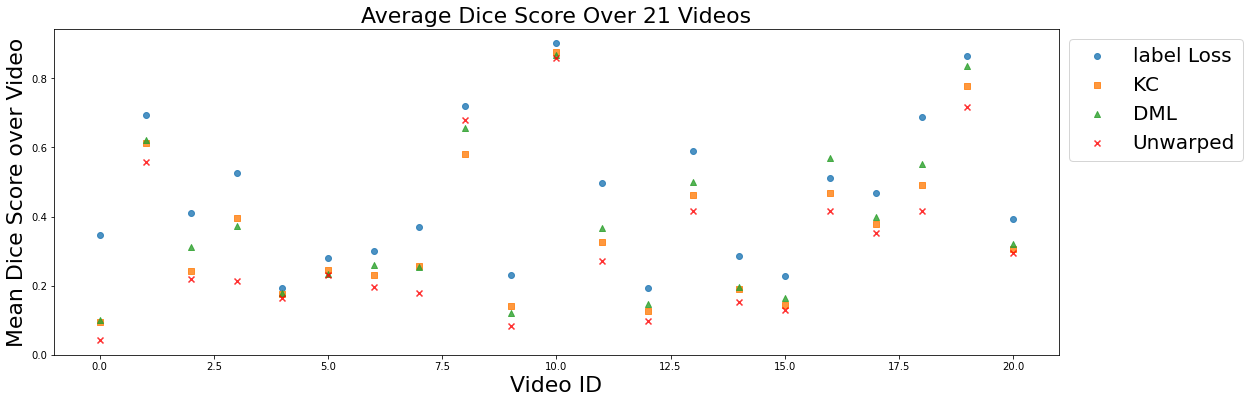

In [16]:
fonts = {'fontsize': 22,'family': 'Latin Modern Roman'}

fig = plt.figure(figsize=(18,6))
a = 0.8
plt.scatter(np.arange(c_means.shape[0]),c_means.mean(axis=1), label='label Loss', alpha=a, marker='o')
plt.scatter(np.arange(c_means.shape[0]),kc_means.mean(axis=1), label='KC', alpha=a, marker='s')
plt.scatter(np.arange(c_means.shape[0]),dml_means.mean(axis=1), label='DML', alpha=a, marker='^')
plt.scatter(np.arange(c_means.shape[0]),un_means.mean(axis=1), label='Unwarped', color='red', marker='x', alpha=a)

plt.title(f'Average Dice Score Over {len(ids)} Videos', fontdict=fonts)
plt.xlabel('Video ID', fontdict=fonts)
plt.ylabel("Mean Dice Score over Video",fontdict=fonts)

plt.legend(bbox_to_anchor=(1,1), loc="upper left",fontsize=20)

# Instead of using one Fixed seg
Let's use the predicted segmentation

In [15]:
def eval_id_moving(frames, segs, last_segment_available):
    distance_between_frames = 6


    classic_dice = []#torch.zeros(frames.shape[0],2)
    kc_dice = []#torch.zeros(frames.shape[0],2)
    #dml_dice = []#torch.zeros(frames.shape[0],2)
   
    classic_segs = torch.zeros(segs.shape)
    #base_dice = []#torch.zeros(frames.shape[0],2)
    #flow_dice = []#torch.zeros(frames.shape[0],2)
    #pwc_dice = []#torch.zeros(frames.shape[0],2)
    unwarped = []#torch.zeros(frames.shape[0],2)

    for i, frame in enumerate(frames):

        # skipp first X frames
        if i < distance_between_frames:
            continue
            
        if i-distance_between_frames <= last_segment_available:
            fixed = torch.clone(frames[i- distance_between_frames])
            fixed_seg = torch.clone(segs[i-distance_between_frames])
    
        if i-distance_between_frames > last_segment_available:
            fixed = torch.clone(frames[i-distance_between_frames])
            fixed_seg = torch.clone(classic_segs[i-distance_between_frames])
            
        moving = torch.clone(frames[i])
        moving_seg = torch.clone(segs[i])
        
        # not segmentation available in this seg
        if moving_seg.max().item() == 0.:
            continue

        # LABELLOSS
        pdd_seg, run_time_pdd = pdd_warp(model_classic, fixed, moving, fixed_seg, moving_seg)
        classic_segs[i] = pdd_seg.detach()
        classic_dice.append(dice_coeff(moving_seg, pdd_seg, 3))

        # KC
        pdd_seg, run_time_pdd = pdd_warp(model_kc, fixed, moving, fixed_seg, moving_seg)
        #kc_segs[i] = pdd_seg
        kc_dice.append(dice_coeff(moving_seg, pdd_seg, 3))

        # DML
        #pdd_seg, run_time_pdd = pdd_warp(model_dml, fixed, moving, fixed_seg, moving_seg)
        #dml_segs[i] = pdd_seg
        #dml_dice.append(dice_coeff(moving_seg, pdd_seg, 3))
        
        #base_d, run_time_base = eval_baseline(fixed.cpu(), moving.cpu(), fixed_seg, moving_seg)
        #base_dice.append(base_d)
        
        #warped_seg, _ = flownet_warp(fixed.unsqueeze(0).unsqueeze(0), moving.unsqueeze(0).unsqueeze(0), fixed_seg, moving_seg)
        #flow_dice.append(dice_coeff(moving_seg.cpu(), warped_seg, 3).cpu())

        # PWC
        #warped_seg, run_time = pwc_warp(fixed.unsqueeze(0).unsqueeze(0),moving.unsqueeze(0).unsqueeze(0),fixed_seg,moving_seg)
        #pwc_dice.append(dice_coeff(moving_seg.cpu(), warped_seg, 3).cpu())
        
        unwarped.append(dice_coeff(fixed_seg,moving_seg,3))
        
    
    classic_tensor = torch.stack(classic_dice)
    kc_tensor = torch.stack(kc_dice)
    #dml_tensor = torch.stack(dml_dice)
    #base_tensor = torch.stack(base_dice)
    #flow_tensor = torch.stack(flow_dice)
    #pwc_tensor = torch.stack(pwc_dice)
    unwarped = torch.stack(unwarped)
    
    return classic_tensor, kc_tensor, unwarped#dml_tensor, base_tensor, flow_tensor, pwc_tensor, unwarped

In [17]:
path_to_data = "/share/data_ultraschall/compressions"
#ids = [157, 384, 717, 209, 106, 4808, 977, 1097, 1150, 1314, 58, 115, 2709, 2713,4814, 2199, 545, 216, 610, 341, 526, 12, 124, 1778, 195, 379, 327, 384, 2033, 797]
ids = [3485, 2232, 3455, 5687, 3360, 3672, 3357, 3628, 3538, 3352, 3586, 3433, 3644, 3387, 3663,3424, 2219, 3649, 3335, 3397, 3683]

overall_classic_dice = []
overall_kc_dice = []
overall_dml_dice = []

overall_seq_classic_dice = []
overall_seq_kc_dice = []
overall_seq_dml_dice = []

overall_base_dice = []
overall_flow_dice = []
overall_pwc_dice = []
overall_unwarped = []

for prob_id in ids:
    print(prob_id)
    frame_path = os.path.join(path_to_data,str(prob_id),'frames')
    seg_path = os.path.join(path_to_data,str(prob_id),'segmentations','1')

    frame_list = []
    for frame in os.listdir(frame_path):
        frame_list.append(os.path.join(frame_path,frame))
    frame_list.sort()

    seg_list = []
    for seg in os.listdir(seg_path):
        seg_list.append(os.path.join(seg_path,seg))
    seg_list.sort()

    assert len(frame_list) == len(seg_list)
    frames = torch.zeros([len(frame_list), 150,150])
    segs = torch.zeros([len(frame_list), 150,150])
    # read images
    for i in range(len(frame_list)):
        frames[i] = torch.from_numpy(np.array(Image.open(frame_list[i]))).float()
        segs[i] = torch.from_numpy(np.array(Image.open(seg_list[i])))
    
    # normalize if needed
    if segs.max() > 3:
        segs = segs / 100    
    if frames.max() > 2:
         frames = frames / 255

    landmarks = pd.read_csv('landmarks.csv')
    landmarks = landmarks[landmarks['Id'].isin(ids)]
    if prob_id in landmarks.Id.to_numpy():
        start_frame = landmarks[landmarks['Id']== prob_id]['Start Frames'].iat[0]
        #print(start_frame)
        if isinstance(start_frame, str):
            last_segment_available = np.fromstring(start_frame.strip(']['), sep=',', dtype=int)
            
        else:
            last_segment_available = start_frame
    else:
        last_segment_available = 3
    if segs.max().item() == 0.:
        print('id not good: ', prob_id)
        continue
        
    #classic_dice, kc_dice, dml_dice, seq_classic_dice, seq_kc_dice, seq_dml_dice , base_dice, flow_dice, pwc_dice, unwarped
    c_d, kc_d,un = eval_id_moving(frames,segs, last_segment_available)
    
    overall_classic_dice.append(c_d)
    overall_kc_dice.append(kc_d)
    #overall_dml_dice.append(dml_d)
    
    #overall_base_dice.append(base)
    #overall_flow_dice.append(f_d)
    #overall_pwc_dice.append(pwc_d)
    overall_unwarped.append(un)

3485
2232
3455
5687
3360
3672
3357
3628
3538
3352
3586
3433
3644
3387
3663
3424
2219
3649
3335
3397
3683


In [18]:
c_means = torch.zeros((len(ids), 2))
kc_means = torch.zeros((len(ids), 2))
dml_means = torch.zeros((len(ids), 2))

base_means = torch.zeros((len(ids), 2))
flow_means = torch.zeros((len(ids), 2))
pwc_means = torch.zeros((len(ids), 2))
un_means = torch.zeros((len(ids), 2))



for idx, dice in enumerate(overall_classic_dice):
    
    # MEANS
    c_means[idx] = torch.Tensor([overall_classic_dice[idx][:,0].mean(),overall_classic_dice[idx][:,1].mean()])
    kc_means[idx] = torch.Tensor([overall_kc_dice[idx][:,0].mean(),overall_kc_dice[idx][:,1].mean()])
    #dml_means[idx] = torch.Tensor([overall_dml_dice[idx][:,0].mean(),overall_dml_dice[idx][:,1].mean()])
    
    #base_means[idx] = torch.Tensor([overall_base_dice[idx][:,0].mean(),overall_base_dice[idx][:,1].mean()])
    #flow_means[idx] = torch.Tensor([overall_flow_dice[idx][:,0].mean(),overall_flow_dice[idx][:,1].mean()])
    #pwc_means[idx] = torch.Tensor([overall_pwc_dice[idx][:,0].mean(),overall_pwc_dice[idx][:,1].mean()])
    un_means[idx] = torch.Tensor([overall_unwarped[idx][:,0].mean(),overall_unwarped[idx][:,1].mean()])


In [19]:
print("Unwapred:")
print("Vein: ", round(un_means[:,0].mean().item()*100,2)," $\pm$ ", round(un_means[:,0].var().item()*100,3))
print("Artery: ", round(un_means[:,1].mean().item()*100,3)," $\pm$ ", round(un_means[:,1].var().item()*100,3))
print("Overall: ", round(un_means.mean().item()*100,3)," $\pm$ ", round(un_means.var().item()*100,3))
print()

Unwapred:
Vein:  23.98  $\pm$  5.049
Artery:  24.159  $\pm$  5.106
Overall:  24.07  $\pm$  4.954



In [20]:
print("Classic:")
print("Vein: ", round(c_means[:,0].mean().item()*100,2)," $\pm$ ", round(c_means[:,0].var().item()*100,2))
print("Artery: ", round(c_means[:,1].mean().item()*100,2)," $\pm$ ", round(c_means[:,1].var().item()*100,2))
print("Overall: ", round(c_means.mean().item()*100,2)," $\pm$ ", round(c_means.var().item()*100,2))
print()

print("KC:")
print("Vein: ", round(kc_means[:,0].mean().item()*100,2)," $\pm$ ", round(kc_means[:,0].var().item()*100,2))
print("Artery: ", round(kc_means[:,1].mean().item()*100,2)," $\pm$ ", round(kc_means[:,1].var().item()*100,2))
print("Overall: ", round(kc_means.mean().item()*100,2)," $\pm$ ", round(kc_means.var().item()*100,2))
print()

print("DML:")
print("Vein: ", round(dml_means[:,0].mean().item()*100,2)," $\pm$ ", round(dml_means[:,0].var().item()*100,2))
print("Artery: ", round(dml_means[:,1].mean().item()*100,2)," $\pm$ ", round(dml_means[:,1].var().item()*100,2))
print("Overall: ", round(dml_means.mean().item()*100,2)," $\pm$ ", round(dml_means.var().item()*100,2))
print()

Classic:
Vein:  25.72  $\pm$  5.38
Artery:  27.51  $\pm$  5.4
Overall:  26.62  $\pm$  5.27

KC:
Vein:  25.96  $\pm$  5.23
Artery:  28.11  $\pm$  5.43
Overall:  27.04  $\pm$  5.21

DML:
Vein:  0.0  $\pm$  0.0
Artery:  0.0  $\pm$  0.0
Overall:  0.0  $\pm$  0.0



In [21]:
print("Flow2:")
print("Vein: ", round(flow_means[:,0].mean().item()*100,2)," $\pm$ ", round(flow_means[:,0].var().item()*100,2))
print("Artery: ", round(flow_means[:,1].mean().item()*100,2), " $\pm$ ",round(flow_means[:,1].var().item()*100,2))
print("Overall: ", round(flow_means.mean().item()*100,2)," $\pm$ ", round(flow_means.var().item()*100,2))
print()

print("PWC:")
print("Vein: ", round(pwc_means[:,0].mean().item()*100,2)," $\pm$ ", round(pwc_means[:,0].var().item()*100,2))
print("Artery: ", round(pwc_means[:,1].mean().item()*100,2)," $\pm$ ", round(pwc_means[:,1].var().item()*100,2))
print("Overall: ", round(pwc_means.mean().item()*100,2)," $\pm$ ", round(pwc_means.var().item()*100,2))
print()

print("Dual:")
print("Vein: ", round(base_means[:,0].mean().item()*100,2)," $\pm$ ", round(base_means[:,0].var().item()*100,2))
print("Artery: ", round(base_means[:,1].mean().item()*100,2)," $\pm$ ", round(base_means[:,1].var().item()*100,2))
print("Overall: ", round(base_means.mean().item()*100,2)," $\pm$ ", round(base_means.var().item()*100,2))
print()

Flow2:
Vein:  0.0  $\pm$  0.0
Artery:  0.0  $\pm$  0.0
Overall:  0.0  $\pm$  0.0

PWC:
Vein:  0.0  $\pm$  0.0
Artery:  0.0  $\pm$  0.0
Overall:  0.0  $\pm$  0.0

Dual:
Vein:  0.0  $\pm$  0.0
Artery:  0.0  $\pm$  0.0
Overall:  0.0  $\pm$  0.0



# For completenes sake


In [15]:
def eval_id_all(frames, segs, last_segment_available):
    distance_between_frames = 6


    classic_dice = []#torch.zeros(frames.shape[0],2)
    classic_hd = []
    kc_dice = []#torch.zeros(frames.shape[0],2)
    kc_hd = []
    #dml_dice = []#torch.zeros(frames.shape[0],2)
   
    #base_dice = []#torch.zeros(frames.shape[0],2)
    #flow_dice = []#torch.zeros(frames.shape[0],2)
    #pwc_dice = []#torch.zeros(frames.shape[0],2)
    unwarped = []#torch.zeros(frames.shape[0],2)

    for i, frame in enumerate(frames):

        # skipp first X frames
        if i < distance_between_frames:
            continue
            
        fixed = torch.clone(frames[i- distance_between_frames])
        fixed_seg = torch.clone(segs[i-distance_between_frames])
            
        moving = torch.clone(frames[i])
        moving_seg = torch.clone(segs[i])

                # not segmentation available in this seg
        if moving_seg.max().item() == 0.:
            continue

        # LABELLOSS
        pdd_seg, run_time_pdd = pdd_warp(model_classic, fixed, moving, fixed_seg, moving_seg)
        #classic_segs[i] = pdd_seg
        classic_dice.append(dice_coeff(moving_seg, pdd_seg, 3))
        classic_hd.append(hausdorff_dist(moving_seg.unsqueeze(0), pdd_seg.unsqueeze(0), 3))

        # KC
        pdd_seg, run_time_pdd = pdd_warp(model_kc, fixed, moving, fixed_seg, moving_seg)
        #kc_segs[i] = pdd_seg
        kc_dice.append(dice_coeff(moving_seg, pdd_seg, 3))
        kc_hd.append(hausdorff_dist(moving_seg.unsqueeze(0), pdd_seg.unsqueeze(0), 3))

        # DML
        #pdd_seg, run_time_pdd = pdd_warp(model_dml, fixed, moving, fixed_seg, moving_seg)
        #dml_segs[i] = pdd_seg
        #dml_dice.append(dice_coeff(moving_seg, pdd_seg, 3))
        
        #base_d, run_time_base = eval_baseline(fixed.cpu(), moving.cpu(), fixed_seg, moving_seg)
        #base_dice.append(base_d)
        
        #warped_seg, _ = flownet_warp(fixed.unsqueeze(0).unsqueeze(0), moving.unsqueeze(0).unsqueeze(0), fixed_seg, moving_seg)
        #flow_dice.append(dice_coeff(moving_seg.cpu(), warped_seg, 3).cpu())

        # PWC
        #warped_seg, run_time = pwc_warp(fixed.unsqueeze(0).unsqueeze(0),moving.unsqueeze(0).unsqueeze(0),fixed_seg,moving_seg)
        #pwc_dice.append(dice_coeff(moving_seg.cpu(), warped_seg, 3).cpu())
        
        unwarped.append(dice_coeff(fixed_seg,moving_seg,3))
        
    
    classic_tensor = torch.stack(classic_dice)
    kc_tensor = torch.stack(kc_dice)
    c_hd = torch.stack(classic_hd)
    kc_hd = torch.stack(kc_hd)
    
    
    #dml_tensor = torch.stack(dml_dice)
    #base_tensor = torch.stack(base_dice)
    #flow_tensor = torch.stack(flow_dice)
    #pwc_tensor = torch.stack(pwc_dice)
    #unwarped = torch.stack(unwarped)
    
    return classic_tensor,c_hd, kc_tensor, kc_hd#, dml_tensor, base_tensor, flow_tensor, pwc_tensor, unwarped

In [16]:
path_to_data = "/share/data_ultraschall/compressions"
#ids = [157, 384, 717, 209, 106, 4808, 977, 1097, 1150, 1314, 58, 115, 2709, 2713,4814, 2199, 545, 216, 610, 341, 526, 12, 124, 1778, 195, 379, 327, 384, 2033, 797]
ids = [3485, 2232, 3455, 5687, 3360, 3672, 3357, 3628, 3538, 3352, 3586, 3433, 3644, 3387, 3663,3424, 2219, 3649, 3335, 3397, 3683]


overall_classic_dice = []
overall_c_hd = []
overall_kc_dice = []
overall_kc_hd = []
overall_dml_dice = []

overall_seq_classic_dice = []
overall_seq_kc_dice = []
overall_seq_dml_dice = []

overall_base_dice = []
overall_flow_dice = []
overall_pwc_dice = []
overall_unwarped = []

for prob_id in ids:
    
    print(prob_id)
    frame_path = os.path.join(path_to_data,str(prob_id),'frames')
    seg_path = os.path.join(path_to_data,str(prob_id),'segmentations','1')

    frame_list = []
    for frame in os.listdir(frame_path):
        frame_list.append(os.path.join(frame_path,frame))
    frame_list.sort()

    seg_list = []
    for seg in os.listdir(seg_path):
        seg_list.append(os.path.join(seg_path,seg))
    seg_list.sort()

    assert len(frame_list) == len(seg_list)
    frames = torch.zeros([len(frame_list), 150,150])
    segs = torch.zeros([len(frame_list), 150,150])
    # read images
    for i in range(len(frame_list)):
        frames[i] = torch.from_numpy(np.array(Image.open(frame_list[i]))).float()
        segs[i] = torch.from_numpy(np.array(Image.open(seg_list[i])))
    
    # normalize if needed
    if segs.max() > 3:
        segs = segs / 100    
    if frames.max() > 2:
         frames = frames / 255

    landmarks = pd.read_csv('landmarks.csv')
    landmarks = landmarks[landmarks['Id'].isin(ids)]
    if prob_id in landmarks.Id.to_numpy():
        start_frame = landmarks[landmarks['Id']== prob_id]['Start Frames'].iat[0]
        #print(start_frame)
        if isinstance(start_frame, str):
            last_segment_available = np.fromstring(start_frame.strip(']['), sep=',', dtype=int)
            
        else:
            last_segment_available = start_frame
    else:
        last_segment_available = 3
    if segs.max().item() == 0.:
        print('id not good: ', prob_id)
        continue
    
    
    #classic_dice, kc_dice, dml_dice, seq_classic_dice, seq_kc_dice, seq_dml_dice , base_dice, flow_dice, pwc_dice, unwarped
    #c_d, kc_d,un = eval_id_all(frames,segs, last_segment_available)
    c_d, c_hd, kc_d, kc_hd = eval_id_all(frames,segs, last_segment_available)
    
    overall_classic_dice.append(c_d)
    overall_c_hd.append(torch.from_numpy(np.nan_to_num(c_hd.numpy(), posinf=np.nan)))
    
    overall_kc_dice.append(kc_d)
    overall_kc_hd.append(torch.from_numpy(np.nan_to_num(kc_hd.numpy(), posinf=np.nan)))
    

3485
2232
3455
5687
3360
3672
3357
3628
3538
3352
3586
3433
3644
3387
3663
3424
2219
3649
3335
3397
3683


In [17]:
c_means = torch.zeros((len(ids), 2))
c_hds = torch.zeros((len(ids), 2))
kc_means = torch.zeros((len(ids), 2))
kc_hds = torch.zeros((len(ids), 2))

dml_means = torch.zeros((len(ids), 2))


base_means = torch.zeros((len(ids), 2))
flow_means = torch.zeros((len(ids), 2))
pwc_means = torch.zeros((len(ids), 2))
un_means = torch.zeros((len(ids), 2))


for idx, dice in enumerate(overall_classic_dice):
    
    # MEANS DICE
    c_means[idx] = torch.Tensor([overall_classic_dice[idx][:,0].mean(),overall_classic_dice[idx][:,1].mean()])
    kc_means[idx] = torch.Tensor([overall_kc_dice[idx][:,0].mean(),overall_kc_dice[idx][:,1].mean()])
    #dml_means[idx] = torch.Tensor([overall_dml_dice[idx][:,0].mean(),overall_dml_dice[idx][:,1].mean()])
    
    #base_means[idx] = torch.Tensor([overall_base_dice[idx][:,0].mean(),overall_base_dice[idx][:,1].mean()])
    #flow_means[idx] = torch.Tensor([overall_flow_dice[idx][:,0].mean(),overall_flow_dice[idx][:,1].mean()])
    #pwc_means[idx] = torch.Tensor([overall_pwc_dice[idx][:,0].mean(),overall_pwc_dice[idx][:,1].mean()])
    #un_means[idx] = torch.Tensor([overall_unwarped[idx][:,0].mean(),overall_unwarped[idx][:,1].mean()])
    
    # MEANS HD
    c_hds[idx] = torch.Tensor([np.nanmean(overall_c_hd[idx][:,0]),np.nanmean(overall_c_hd[idx][:,1])])
    kc_hds[idx] = torch.Tensor([np.nanmean(overall_kc_hd[idx][:,0]),np.nanmean(overall_kc_hd[idx][:,1])])
    

In [25]:
print("Unwapred:")
print("Vein: ", round(un_means[:,0].mean().item()*100,2)," $\pm$ ", round(un_means[:,0].var().item()*100,3))
print("Artery: ", round(un_means[:,1].mean().item()*100,3)," $\pm$ ", round(un_means[:,1].var().item()*100,3))
print("Overall: ", round(un_means.mean().item()*100,3)," $\pm$ ", round(un_means.var().item()*100,3))
print()

Unwapred:
Vein:  46.11  $\pm$  3.706
Artery:  55.011  $\pm$  2.667
Overall:  50.562  $\pm$  3.312



In [18]:
print("Classic:")
print("Vein: ", round(c_means[:,0].mean().item()*100,2)," $\pm$ ", round(c_means[:,0].var().item()*100,2), ' ; ', round(c_hds[:,0].mean().item(),2)," $\pm$ ", round(c_hds[:,0].var().item(),2))
print("Artery: ", round(c_means[:,1].mean().item()*100,2)," $\pm$ ", round(c_means[:,1].var().item()*100,2), ' ; ', round(c_hds[:,1].mean().item(),2)," $\pm$ ", round(c_hds[:,1].var().item(),2))
print("Overall: ", round(c_means.mean().item()*100,2)," $\pm$ ", round(c_means.var().item()*100,2), ' ; ', round(c_hds.mean().item(),2)," $\pm$ ", round(c_hds.var().item(),2))
print()

print("KC:")
print("Vein: ", round(kc_means[:,0].mean().item()*100,2)," $\pm$ ", round(kc_means[:,0].var().item()*100,2), ' ; ', round(kc_hds[:,0].mean().item(),2)," $\pm$ ", round(kc_hds[:,0].var().item(),2))
print("Artery: ", round(kc_means[:,1].mean().item()*100,2)," $\pm$ ", round(kc_means[:,1].var().item()*100,2), ' ; ', round(kc_hds[:,1].mean().item(),2)," $\pm$ ", round(kc_hds[:,1].var().item(),2))
print("Overall: ", round(kc_means.mean().item()*100,2)," $\pm$ ", round(kc_means.var().item()*100,2), ' ; ', round(kc_hds.mean().item(),2)," $\pm$ ", round(kc_hds.var().item(),2))
print()

print("DML:")
print("Vein: ", round(dml_means[:,0].mean().item()*100,2)," $\pm$ ", round(dml_means[:,0].var().item()*100,2))
print("Artery: ", round(dml_means[:,1].mean().item()*100,2)," $\pm$ ", round(dml_means[:,1].var().item()*100,2))
print("Overall: ", round(dml_means.mean().item()*100,2)," $\pm$ ", round(dml_means.var().item()*100,2))
print()

Classic:
Vein:  54.73  $\pm$  4.2  ;  14.74  $\pm$  75.53
Artery:  71.64  $\pm$  1.95  ;  13.52  $\pm$  84.97
Overall:  63.18  $\pm$  3.73  ;  14.13  $\pm$  78.68

KC:
Vein:  47.9  $\pm$  3.7  ;  16.54  $\pm$  68.9
Artery:  59.7  $\pm$  2.5  ;  15.18  $\pm$  76.25
Overall:  53.8  $\pm$  3.38  ;  15.86  $\pm$  71.28

DML:
Vein:  0.0  $\pm$  0.0
Artery:  0.0  $\pm$  0.0
Overall:  0.0  $\pm$  0.0



In [71]:
print("Flow2:")
print("Vein: ", round(flow_means[:,0].mean().item()*100,2)," $\pm$ ", round(flow_means[:,0].var().item()*100,2))
print("Artery: ", round(flow_means[:,1].mean().item()*100,2), " $\pm$ ",round(flow_means[:,1].var().item()*100,2))
print("Overall: ", round(flow_means.mean().item()*100,2)," $\pm$ ", round(flow_means.var().item()*100,2))
print()

print("PWC:")
print("Vein: ", round(pwc_means[:,0].mean().item()*100,2)," $\pm$ ", round(pwc_means[:,0].var().item()*100,2))
print("Artery: ", round(pwc_means[:,1].mean().item()*100,2)," $\pm$ ", round(pwc_means[:,1].var().item()*100,2))
print("Overall: ", round(pwc_means.mean().item()*100,2)," $\pm$ ", round(pwc_means.var().item()*100,2))
print()

print("Dual:")
print("Vein: ", round(base_means[:,0].mean().item()*100,2)," $\pm$ ", round(base_means[:,0].var().item()*100,2))
print("Artery: ", round(base_means[:,1].mean().item()*100,2)," $\pm$ ", round(base_means[:,1].var().item()*100,2))
print("Overall: ", round(base_means.mean().item()*100,2)," $\pm$ ", round(base_means.var().item()*100,2))
print()

Flow2:
Vein:  47.63  $\pm$  2.84
Artery:  60.09  $\pm$  1.86
Overall:  53.86  $\pm$  2.69

PWC:
Vein:  49.26  $\pm$  3.65
Artery:  62.39  $\pm$  1.68
Overall:  55.83  $\pm$  3.04

Dual:
Vein:  49.52  $\pm$  3.48
Artery:  62.04  $\pm$  2.22
Overall:  55.78  $\pm$  3.18



# Test this against the nnU-Net predictions

In [24]:
#ids = [3485, 2232, 4333, 3753, 3455, 5687, 3360, 3672, 3357, 2098, 4242, 3933, 3628, 3538, 5209, 4160, 3352, 3586, 3433, 3644, 3387, 3663,3424, 2219, 3649, 3335, 4186, 3397, 3683]

ids = {2098: 0,
3424: 1,
5687: 2,
3649: 3,
2219: 4,
3360: 5,
3352: 6,
3357: 7,
3397: 8,
3455: 9,
1703: 10,
3387: 11,
3485: 12,
3433: 13,
3335: 14,
3663: 15,
3538: 16,
3644: 17,
3628: 18,
3586: 19,
3683: 20,
3672: 21,
2232: 22}
pred_path = '/share/data_ultraschall/result_segmentations_nnunet2d/predict'
path_to_data = "/share/data_ultraschall/compressions"


In [25]:
import json
import nibabel as nib

In [26]:
results_dict = json.load(open(os.path.join(pred_path,'summary.json')))

In [27]:
result_list = results_dict['results']['all']

In [28]:
dice = []

for r in result_list:
    dice.append([r['1']['Dice'],r['2']['Dice']])

In [29]:
dice = np.array(dice)
print(f"{round(dice.mean(axis=0)[0] * 100,2)} $\pm$ {round(dice.var(axis=0)[0] * 100,2)} & {round(dice.mean(axis=0)[1] * 100,2)} $\pm$ {round(dice.var(axis=0)[1] * 100,2)} & {round(dice.mean() * 100,2)} $\pm$ {round(dice.var() * 100,2)} ") 
     # &  {round(dice.mean(axis=0)[1] * 100,2)} $\pm$ {round(dice.var(axis=0)[1] * 100,2)} 
     # & {round(dice.mean(axis=0) * 100,2)} $\pm$ {round(dice.var(axis=0) * 100,2)}
     # ")

62.46 $\pm$ 7.77 & 68.97 $\pm$ 6.31 & 65.72 $\pm$ 7.15 


In [30]:
pred_path = '/share/data_ultraschall/result_segmentations_nnunet2d/predict'
path_to_data = "/share/data_ultraschall/compressions"

mapping = {}

prediction_list = os.listdir(pred_path)
prediction_list.sort()
#print(len(prediction_list))

nii_files = []
for idx,f in enumerate(prediction_list):
    if '.nii.gz' in f:
        nii_files.append(f)
nii_files.sort()
print(nii_files)
#for f in os.listdir(pred_path):
#    if '.nii.gz' in f:
#        example = nib.load(os.path.join(pred_path,f)).get_fdata()
#        for prob_id in ids:
#            examp_path = os.path.join(path_to_data, str(prob_id), 'segmentations', '1')
#            if example.shape[0] == len(os.listdir(examp_path)):
#                mapping[f] = str(prob_id)
                #print(f, prob_id, example.shape, len(os.listdir(examp_path)))

['000.nii.gz', '001.nii.gz', '002.nii.gz', '003.nii.gz', '004.nii.gz', '005.nii.gz', '006.nii.gz', '007.nii.gz', '008.nii.gz', '009.nii.gz', '010.nii.gz', '011.nii.gz', '012.nii.gz', '013.nii.gz', '014.nii.gz', '015.nii.gz', '016.nii.gz', '017.nii.gz', '018.nii.gz', '019.nii.gz', '020.nii.gz', '021.nii.gz', '022.nii.gz', '023.nii.gz']


In [31]:
HDs = []
Dice = []

for idx, key in enumerate(ids.keys()):
    pred = torch.from_numpy(nib.load(os.path.join(pred_path,nii_files[idx])).get_fdata())
    gt = torch.zeros(pred.shape)
    gt_path = os.path.join(path_to_data, str(key), 'segmentations', '1')
    gt_files = os.listdir(gt_path)
    gt_files.sort()
    for idx, f in enumerate(gt_files):
        gt[idx] = torch.from_numpy(np.array(Image.open(os.path.join(gt_path,f)))) / 100
    
    hd_tmp = []
    dice_tmp = []
    for i in range(gt.shape[0]):
        hd_tmp.append(hausdorff_dist(pred[i].unsqueeze(0), gt[i].unsqueeze(0), 3).numpy())
        dice_tmp.append(dice_coeff(pred[i], gt[i], 3).numpy())
    
    HDs.append(np.array(hd_tmp))    
    Dice.append(np.array(dice_tmp))

HDs = np.array(HDs)
Dice = np.array(Dice)

In [41]:
mean_d = []
mean_hd = []
for j in range(HDs.shape[0]):
    mean_d.append(np.array([Dice[j][:,0].mean(), Dice[j][:,1].mean()]))
    mean_hd.append(np.array([np.nanmean(np.nan_to_num(HDs[j][:,0], posinf=np.nan)), np.nanmean(np.nan_to_num(HDs[j][:,1], posinf=np.nan))]))
    
mean_d = np.array(mean_d) 
mean_hd = np.array(mean_hd) 

In [42]:
print(mean_d[:,0].mean(),mean_d[:,0].var() ,mean_d[:,1].mean(), mean_d[:,1].var(), mean_d.mean(), mean_d.var())
print(np.nanmean(mean_hd[:,0]),np.nanvar(mean_hd[:,0]) ,mean_hd[:,1].mean(), mean_hd[:,1].var(), np.nanmean(mean_hd), np.nanvar(mean_hd))

0.4593476 0.06472208 0.66800773 0.06903888 0.56367767 0.07776525
23.716608 366.0648 26.883762 640.51086 25.335377 508.84372
